# Generative Adverserial Imitation Learning

Generative Adversarial Imitation Learning (GAIL) was first proposed in the paper [Generative Adversarial Imitation Learning](https://arxiv.org/abs/1606.03476) by Jonathan Ho and Stefano Ermon. The project task is to implement the Generative Adverserial Imitation Learning model for driving scenarios using the bark-simulator.

GAIL is based on the setting of Reinforcement Learning (RL). In Reinforcment Learning, the agent interacts with the environment through its actions and receives rewards in return. The aim of the learning process is to maximize the cummulative reward by chosing the best action in all states.

As the name suggests, GAIL belongs to a smaller subgroup of RL, called Imitation Learning. In this setup the goal of the agent is to mimic an expert behavior as closely as possible. The environment awards higher rewards to expert-like behavior and smaller ones to actions which substantially deviate from the expert behavior. In our case, expert trajectories were generated from real life data, namely from the interaction dataset, as well as from a pretrained SAC (Soft Actor-Critic) agent. The expert trajectories, which are obtained in this way, represent the expert knowledge by containing many states with corresponding actions that were produced by the expert.

As mentioned previously, learning of the agent in the RL setting is driven by the rewards it receives from the environment. The amount of the reward in the Imitation Learning setting are determined based on how closely the agent mimics the expert behavior. Special in the GAIL approach is that we receive the reward from an adversarial game: The agent is represented by a generator network which is trained based on the feedback of a discriminator network. The generator produces actions for given states which are then evaluated by the discriminator. In the meantime, the discriminator is trained by feeding it with expert and agent state-action pairs for classification. This way, the generator tries to fool the discriminator, hence he aims at acting as expert-like as possible. Meanwhile, the discriminator tries to distinguish between expert and agent trajectories. Intuitively, learning converges when the generator learned to act so similarly to the expert that the discriminator cannot tell apart expert and agent trajectories any more. In game theory this point is called the Nash-equilibrium.

In practice, the implementation of a GAIL agent is usually solved in the following way for sample efficiency: The agent interacts with the environment by following its actual policy and hence agent state-action pairs are generated. These points are stored in a replay buffer for further learning. After a specified interval a training step is carried out. This training step has 2 substeps: training the discriminator and training the generator networks. 
* __Discriminator training:__ The discriminator is fed a batch of expert (from the expert trajectories) and agent (from the replay buffer) state-action pairs. It classifies all of them. Based on their true labels the loss is calculated and a gradient descent step is carried out in order to minimize the loss.
* __Generator training:__ The generator is fed a batch of states from the replay buffer and it produces actions for them. The resulting state-action pairs are fed to the discriminator for classification. The negative output of the discriminator is used as a loss for the generator network. (Close to -1 if the agent mimics the expert successfully.) The gradient of the loss is propagated all the way back to the generator network to carry out a gradient step for minimizing the it.<br>
As already stated, training runs until both, the generator and the discriminator loss, converge to a steady state value.


The training process is visualized in the following figure:


<img width=70% src="files/data/gail_overview.gif">

## Interaction Dataset
As data source, we used the interaction dataset: https://arxiv.org/abs/1910.03088. Here, we are interested in the merging scenarios: deu_merging_mt and chn_merging_zs. Have a look how the Interaction Dataset is integrated in bark: https://github.com/bark-simulator/bark/blob/setup_tutorials/docs/tutorials/04_interaction_dataset.ipynb (Note that the dataset itself is NOT enclosed with bark due to license limitations).

## Expert Trajectories
As mentioned earlier, we have generated expert trajectories using the Interaction Dataset and also a trained SAC agent. The Interaction Dataset of course contains logs about many different vehicles with different wheel bases. To remedy this issue, we have used a fixed wheel base when calculating the actions from the successive states. This however does not restrict the accuracy of the data. We just consider that all state trajectories were carried out by the same car and calculate the actions that a car would have needed to carry out that behavior. 

As the state variables and also the actions have diferent magnitudes, we normalize all of them for training. The normalization of the expert trajectories takes place while loading the generated expert trajectories. The loading function also takes the actual environment (BARK runtime) as an input, hence the trajectories can be normalized according to the current parameters. (Current state and action spaces.)

## Generate Expert Trajectories
A short example script for generating expert trajectories from the interaction dataset is shown in the following. 

In [1]:
import os 
import bark
from pprint import pprint
from bark_ml.library_wrappers.lib_tf2rl.generate_expert_trajectories import *

tracks_folder = os.path.join(os.getcwd(), 'data')
map_file = os.path.join(os.getcwd(), 'data/DR_DEU_Merging_MT_v01_shifted.xodr')
known_key = ('DR_DEU_Merging_MT_v01_shifted', 'vehicle_tracks_013')
ego_agent = 66

param_server = create_parameter_servers_for_scenarios(map_file, tracks_folder)[known_key]
generation_params = param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"]
generation_params["TrackIds"] = [63, 64, 65, 66, 67, 68]
generation_params["StartTs"] = 232000
generation_params["EndTs"] = 259000
generation_params["EgoTrackId"] = ego_agent
param_server["Scenario"]["Generation"]["InteractionDatasetScenarioGeneration"] = generation_params

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated 

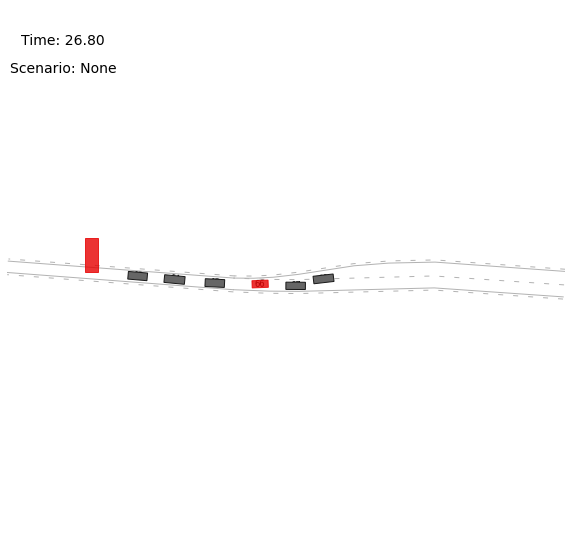

In [2]:
expert_trajectories = generate_expert_trajectories_for_scenario(param_server, sim_time_step=200, renderer="matplotlib_jupyter")

### The generated expert trajectories
The generated expert trajectories are stored in a dictionary with keys:
* `obs`: list, containing the observation vector for the timestep.
* `act`: list, containing the action that was carried out in that timestep.
* `next_obs`: list, the next observation after carrying out the action `act` in the state `obs`. 

The following two cells show some example states and actions to allow for a better understanding of the format.

In [3]:
# Small number of observations for our agent
print(f'Observations for the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['obs'][:5])

Observations for the agent 66

[array([ 998.184021  , 1006.93701172,    3.08599997,    2.19539237,
        995.9619751 , 1004.27398682,    3.05999994,    1.66448367,
       1004.67498779, 1006.34100342,    3.06100011,    1.7957828 ,
       1004.05700684, 1003.58398438,    3.07299995,    1.92759383]),
 array([ 997.74597168, 1006.9619751 ,    3.08599997,    2.18845916,
        995.63201904, 1004.30102539,    3.05999994,    1.62844038,
       1004.31799316, 1006.36901855,    3.06200004,    1.77660406,
       1003.67797852, 1003.60699463,    3.07500005,    1.82607996]),
 array([ 997.30999756, 1006.98699951,    3.08500004,    2.17947364,
        995.309021  , 1004.32800293,    3.05900002,    1.59439075,
       1003.96502686, 1006.39697266,    3.06200004,    1.75758469,
       1003.31799316, 1003.62902832,    3.07599998,    1.72271013]),
 array([ 996.875     , 1007.01202393,    3.08500004,    2.16549611,
        994.99298096, 1004.35498047,    3.05900002,    1.56133819,
       1003.61499023,

`expert_trajectories[ego_agent]['obs'][i]` contains 

\begin{align*}
\begin{pmatrix}
x \\
y \\
\Theta \\
v
\end{pmatrix}
\text{ for the ego vehicle and the three nearest vehicles in the scene, where $x$ and $y$ are 2D coordinates, $\Theta$ is orientation and $v$ velocity.}
\end{align*}

In [4]:
# Small number of actions for our agent
print(f'Actions of the agent {ego_agent}\n')
pprint(expert_trajectories[ego_agent]['act'][:5])

Actions of the agent 66

[[-0.034666060884802626, 0.0],
 [-0.044927593029058605, -0.006168197873944377],
 [-0.06988764225766911, 0.0],
 [-0.09983778594957507, -0.006233605047211027],
 [-0.1200890254762112, 0.0]]


`expert_trajectories[ego_agent]['act'][i]` contains 

\begin{align*}
\begin{pmatrix}
a \\
\delta 
\end{pmatrix}
\text{, where $a$ is acceleration and $\delta$ is steering angle.}
\end{align*}

## GAIL implementation

### TF2RL implementation
We have chosen an off the shelf implementation, the library [TF2RL](https://github.com/keiohta/tf2rl). It implements several reinforcement learning algorithms in [tensorflow 2](https://www.tensorflow.org/guide/effective_tf2). 

The GAIL agent is built up as follows:
* __Generator:__ A complete DDPG agent with actor and critic networks. Both of them have 2-2 hidden layers.
* __Discriminator:__ A normal discriminator network with 2 hidden layers.

In this respect, the agent is not in the traditional GAIL setup with 2 neural networks. Instead, it actually has 5 networks since the DDPG agent itself has 4 of them for greater stability during training. The DDPG agent's critic network basically receives the judgement of the discriminator network as the reward from the environment and its training aims to maximize this reward.

### Integration into BARK
The integration of the TF2RL based GAIL agent is done along existing BARK concepts and has been done in the following most important classes:
* __TF2RLWrapper:__ Wraps the BARK runtime to match the expectations of TF2RL about the environment. The observation and action normalization also takes place here.
    * source: `bark_ml/library_wrappers/lib_tf2rl/tf2rl_wrapper.py`
* __BehaviorTF2RLAgent:__ Base class for TF2RL based agents.
    * source: `bark_ml/library_wrappers/lib_tf2rl/agents/tf2rl_agent.py`
* __BehaviorGAILAgent:__ The TF2RL based GAIL agent.
    * source: `bark_ml/library_wrappers/lib_tf2rl/agents/gail_agent.py`
* __TF2RLRunner:__ Base class for TF2RL based runners.
    * source: `bark_ml/library_wrappers/lib_tf2rl/runners/tf2rl_runner.py`
* __GAILRunner:__ The TF2RL based GAIL runner.
    * source: `bark_ml/library_wrappers/lib_tf2rl/runners/gail_runner.py`
    
In the followings the training process is demonstrated. Later the performance of a pre-trained agent can be visualized.

---

### Training
The parameters which can be set on demand:
* The number of steps to train for.
* The frequency of testing during training
* The number of episodes in each testing round.

In [5]:
# Customize some parameters here!

max_steps = 100000          # Number of steps to train for.
test_interval = 100         # test in every ... steps.
test_episodes = 5           # number of test episodes.
gpu = 0                     # use -1 for cpu only.

In [6]:
# imports
import os
from pathlib import Path

# BARK imports
from bark_project.bark.runtime.commons.parameters import ParameterServer
from bark.runtime.viewer.matplotlib_viewer import MPViewer
from bark.runtime.viewer.video_renderer import VideoRenderer

# BARK-ML imports
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint, \
  ContinuousMergingBlueprint, ContinuousIntersectionBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf2rl.tf2rl_wrapper import TF2RLWrapper
from bark_ml.library_wrappers.lib_tf2rl.agents.gail_agent import BehaviorGAILAgent
from bark_ml.library_wrappers.lib_tf2rl.runners.gail_runner import GAILRunner
from bark_ml.library_wrappers.lib_tf2rl.load_expert_trajectories import load_expert_trajectories

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


The next cell deletes the previous logs and launches tensorboard. After tensorboard has launched, please go on to the next cell and start the training. The tensorboard window refreshes itself every 30 seconds, but you can also refresh it manually in the upper right corner.

In [7]:
generation_params# Load the TensorBoard notebook extension
%load_ext tensorboard

# launching tensorboard and deleting the previous runs logdirs:
!kill 119065
%rm -r "data/logs"
%mkdir "data/logs"
%tensorboard --logdir "data/logs"

zsh:kill:1: kill 119065 failed: no such process
rm: cannot remove 'data/logs': No such file or directory


/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/commons/xodr_parser.py:108: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if lane.find("userData"):
16:51:00.605 [INFO] (trainer.py:65) Restored None
16:51:00.685 [INFO] (irl_trainer.py:73) Total Epi:     1 Steps:       2 Episode Steps:     2 Return: -1.0000 FPS: 26.28
16:51:01.024 [INFO] (irl_trainer.py:73) Total Epi:     2 Steps:       7 Episode Steps:     5 Return: -1.0000 FPS: 942.90
16:51:01.031 [INFO] (irl_trainer.py:73) Total Epi:     3 Steps:      11 Episode Steps:     4 Return: -1.0000 FPS: 775.57
16:51:01.039 [INFO] (irl_trainer.py:73) Total Epi:     4 Steps:      14 Episode Steps:     3 Return: -1.0000 FPS: 508.51
16:51:01.049 [INFO] (irl_trainer.py:73) Total Epi:     5 Steps:      23 Episode Steps:     9 Return: -1

16:51:01.729 [INFO] (irl_trainer.py:73) Total Epi:    66 Steps:     389 Episode Steps:     2 Return: -1.0000 FPS: 290.31
16:51:01.739 [INFO] (irl_trainer.py:73) Total Epi:    67 Steps:     392 Episode Steps:     3 Return: -1.0000 FPS: 425.06
16:51:01.745 [INFO] (irl_trainer.py:73) Total Epi:    68 Steps:     394 Episode Steps:     2 Return: -1.0000 FPS: 513.26
16:51:01.768 [INFO] (irl_trainer.py:73) Total Epi:    69 Steps:     417 Episode Steps:    23 Return: -1.0000 FPS: 1132.02
16:51:01.774 [INFO] (irl_trainer.py:73) Total Epi:    70 Steps:     419 Episode Steps:     2 Return: -1.0000 FPS: 435.70
16:51:01.782 [INFO] (irl_trainer.py:73) Total Epi:    71 Steps:     425 Episode Steps:     6 Return: -1.0000 FPS: 953.30
16:51:01.788 [INFO] (irl_trainer.py:73) Total Epi:    72 Steps:     428 Episode Steps:     3 Return: -1.0000 FPS: 684.18
16:51:01.796 [INFO] (irl_trainer.py:73) Total Epi:    73 Steps:     431 Episode Steps:     3 Return: -1.0000 FPS: 478.86
16:51:01.806 [INFO] (irl_traine

16:51:02.390 [INFO] (irl_trainer.py:73) Total Epi:   134 Steps:     886 Episode Steps:     5 Return: -1.0000 FPS: 984.60
16:51:02.397 [INFO] (irl_trainer.py:73) Total Epi:   135 Steps:     891 Episode Steps:     5 Return: -1.0000 FPS: 906.95
16:51:02.403 [INFO] (irl_trainer.py:73) Total Epi:   136 Steps:     894 Episode Steps:     3 Return: -1.0000 FPS: 610.06
16:51:02.410 [INFO] (irl_trainer.py:73) Total Epi:   137 Steps:     897 Episode Steps:     3 Return: -1.0000 FPS: 647.63
16:51:02.418 [INFO] (irl_trainer.py:73) Total Epi:   138 Steps:     903 Episode Steps:     6 Return: -1.0000 FPS: 919.40
16:51:02.424 [INFO] (irl_trainer.py:73) Total Epi:   139 Steps:     906 Episode Steps:     3 Return: -1.0000 FPS: 657.61
16:51:02.435 [INFO] (irl_trainer.py:73) Total Epi:   140 Steps:     918 Episode Steps:    12 Return: -1.0000 FPS: 1312.60
16:51:02.450 [INFO] (irl_trainer.py:73) Total Epi:   141 Steps:     939 Episode Steps:    21 Return: -1.0000 FPS: 1503.46
16:51:02.458 [INFO] (irl_train


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



16:51:05.032 [INFO] (irl_trainer.py:73) Total Epi:   155 Steps:    1006 Episode Steps:    11 Return: -1.0000 FPS:  4.42
16:51:05.112 [INFO] (irl_trainer.py:73) Total Epi:   156 Steps:    1011 Episode Steps:     5 Return: -1.0000 FPS: 63.47
16:51:05.215 [INFO] (irl_trainer.py:73) Total Epi:   157 Steps:    1018 Episode Steps:     7 Return: -1.0000 FPS: 68.94
16:51:05.358 [INFO] (irl_trainer.py:73) Total Epi:   158 Steps:    1027 Episode Steps:     9 Return: -1.0000 FPS: 63.76
16:51:05.449 [INFO] (irl_trainer.py:73) Total Epi:   159 Steps:    1033 Episode Steps:     6 Return: -1.0000 FPS: 67.46
16:51:05.528 [INFO] (irl_trainer.py:73) Total Epi:   160 Steps:    1038 Episode Steps:     5 Return: -1.0000 FPS: 64.67
16:51:05.576 [INFO] (irl_trainer.py:73) Total Epi:   161 Steps:    1041 Episode Steps:     3 Return: -1.0000 FPS: 64.10
16:51:05.627 [INFO] (irl_trainer.py:73) Total Epi:   162 Steps:    1044 Episode Steps:     3 Return: -1.0000 FPS: 61.51
16:51:05.661 [INFO] (irl_trainer.py:73) 

16:51:16.315 [INFO] (irl_trainer.py:73) Total Epi:   223 Steps:    1690 Episode Steps:    13 Return: -1.0000 FPS: 65.82
16:51:16.503 [INFO] (irl_trainer.py:73) Total Epi:   224 Steps:    1701 Episode Steps:    11 Return: -1.0000 FPS: 59.32
16:51:16.759 [INFO] (irl_trainer.py:73) Total Epi:   225 Steps:    1718 Episode Steps:    17 Return: -1.0000 FPS: 66.69
16:51:17.050 [INFO] (irl_trainer.py:73) Total Epi:   226 Steps:    1736 Episode Steps:    18 Return: -1.0000 FPS: 62.33
16:51:17.241 [INFO] (irl_trainer.py:73) Total Epi:   227 Steps:    1748 Episode Steps:    12 Return: -1.0000 FPS: 63.34
16:51:17.416 [INFO] (irl_trainer.py:73) Total Epi:   228 Steps:    1759 Episode Steps:    11 Return: -1.0000 FPS: 63.63
16:51:17.621 [INFO] (irl_trainer.py:73) Total Epi:   229 Steps:    1772 Episode Steps:    13 Return: -1.0000 FPS: 64.00
16:51:17.823 [INFO] (irl_trainer.py:73) Total Epi:   230 Steps:    1785 Episode Steps:    13 Return: -1.0000 FPS: 64.73
16:51:17.977 [INFO] (irl_trainer.py:73) 

16:51:31.657 [INFO] (irl_trainer.py:73) Total Epi:   292 Steps:    2633 Episode Steps:     9 Return: -1.0000 FPS: 59.86
16:51:31.906 [INFO] (irl_trainer.py:73) Total Epi:   293 Steps:    2649 Episode Steps:    16 Return: -1.0000 FPS: 64.95
16:51:32.024 [INFO] (irl_trainer.py:73) Total Epi:   294 Steps:    2657 Episode Steps:     8 Return: -1.0000 FPS: 68.38
16:51:32.124 [INFO] (irl_trainer.py:73) Total Epi:   295 Steps:    2663 Episode Steps:     6 Return: -1.0000 FPS: 61.16
16:51:32.313 [INFO] (irl_trainer.py:73) Total Epi:   296 Steps:    2675 Episode Steps:    12 Return: -1.0000 FPS: 64.10
16:51:32.480 [INFO] (irl_trainer.py:73) Total Epi:   297 Steps:    2686 Episode Steps:    11 Return: -1.0000 FPS: 66.56
16:51:32.656 [INFO] (irl_trainer.py:73) Total Epi:   298 Steps:    2697 Episode Steps:    11 Return: -1.0000 FPS: 63.16
16:51:32.881 [INFO] (irl_trainer.py:73) Total Epi:   299 Steps:    2710 Episode Steps:    13 Return: -1.0000 FPS: 58.42
16:51:33.126 [INFO] (irl_trainer.py:73) 

16:51:44.392 [INFO] (irl_trainer.py:73) Total Epi:   360 Steps:    3430 Episode Steps:    16 Return: -1.0000 FPS: 62.32
16:51:44.499 [INFO] (irl_trainer.py:73) Total Epi:   361 Steps:    3437 Episode Steps:     7 Return: -1.0000 FPS: 66.10
16:51:44.658 [INFO] (irl_trainer.py:73) Total Epi:   362 Steps:    3447 Episode Steps:    10 Return: -1.0000 FPS: 63.53
16:51:44.852 [INFO] (irl_trainer.py:73) Total Epi:   363 Steps:    3459 Episode Steps:    12 Return: -1.0000 FPS: 62.43
16:51:45.039 [INFO] (irl_trainer.py:73) Total Epi:   364 Steps:    3471 Episode Steps:    12 Return: -1.0000 FPS: 64.99
16:51:45.211 [INFO] (irl_trainer.py:73) Total Epi:   365 Steps:    3482 Episode Steps:    11 Return: -1.0000 FPS: 64.41
16:51:45.398 [INFO] (irl_trainer.py:73) Total Epi:   366 Steps:    3494 Episode Steps:    12 Return: -1.0000 FPS: 64.87
16:51:45.651 [INFO] (irl_trainer.py:73) Total Epi:   367 Steps:    3509 Episode Steps:    15 Return: -1.0000 FPS: 59.76
16:51:45.897 [INFO] (irl_trainer.py:73) 

KeyboardInterrupt: 

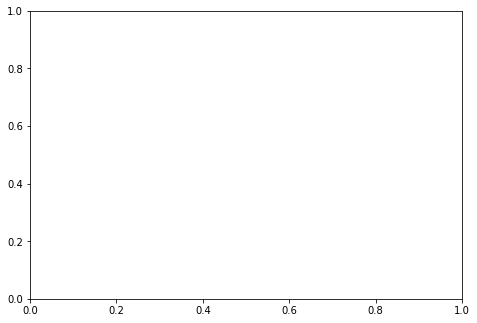

In [8]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
tf2rl_params = params["ML"]["GAILRunner"]["tf2rl"]
tf2rl_params["max_steps"] = max_steps
tf2rl_params["test_interval"] = test_interval
tf2rl_params["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"] = tf2rl_params
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create environment
bp = ContinuousMergingBlueprint(params,
                                number_of_senarios=500,
                                random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                         render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
                           normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                               params=params)

# load the expert trajectories
expert_trajectories, _, _ = load_expert_trajectories(
    params['ML']['ExpertTrajectories']['expert_path_dir'],
    normalize_features=params["ML"]["Settings"]["NormalizeFeatures"],
    env=env, # the unwrapped env has to be used, since that contains the unnormalized spaces.
    subset_size=params["ML"]["ExpertTrajectories"]["subset_size"]
    ) 

# instantiate a runner that is going to train the agent
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,
                 expert_trajs=expert_trajectories)

# train the agent
runner.Train()

### Trained agent visualization
Please set up the number of scenarios to visualize in the next cell!

In [9]:
# number of scenarios to visualize
num_scenarios_to_visualize = 10

/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  linewidth=linewidth)
/home/brucknem/.cache/bazel/_bazel_brucknem/5babddc60bc977a08450e544bfdcfbae/execroot/bark_ml/bazel-out/k8-fastbuild/bin/docs/report/run.runfiles/bark_project/bark/runtime/viewer/matplotlib_viewer.py:49: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated 

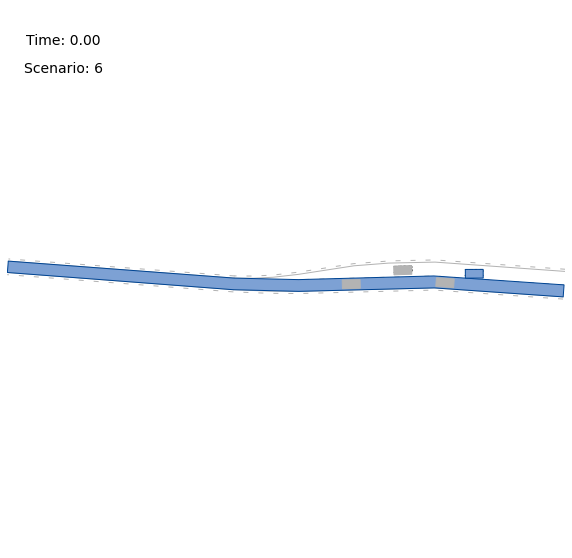

In [ ]:
# load params from the json file to create the parameter server object
params = ParameterServer(filename="data/params/gail_params.json")

# setting the path for the pretrained agent.
params["ML"]["GAILRunner"]["tf2rl"]["model_dir"] = "../../../com_github_gail_4_bark_large_data_store/pretrained_agents/gail/merging"

# customized parameters:
params["ML"]["Settings"]["GPUUse"] = gpu
tf2rl_params = params["ML"]["GAILRunner"]["tf2rl"]
tf2rl_params["max_steps"] = max_steps
tf2rl_params["test_interval"] = test_interval
tf2rl_params["test_episodes"] = test_episodes
params["ML"]["GAILRunner"]["tf2rl"] = tf2rl_params
if params["ML"]["BehaviorGAILAgent"]["WarmUp"] > max_steps / 2:
    params["ML"]["BehaviorGAILAgent"]["WarmUp"] = max_steps / 2

# create environment
bp = ContinuousMergingBlueprint(params,
                              number_of_senarios=500,
                              random_seed=0)
env = SingleAgentRuntime(blueprint=bp,
                      render=False)

# wrapped environment for compatibility with tf2rl
wrapped_env = TF2RLWrapper(env, 
normalize_features=params["ML"]["Settings"]["NormalizeFeatures"])

# instantiate the GAIL agent
gail_agent = BehaviorGAILAgent(environment=wrapped_env,
                           params=params)

# instantiate a runner that is going to train the agent.
runner = GAILRunner(params=params,
                 environment=wrapped_env,
                 agent=gail_agent,)

# Visualize the agent
runner.Visualize(num_scenarios_to_visualize, renderer="matplotlib_jupyter")